# Audio compression with the Fast Fourier Transform

<style type="text/css">
    .exercise {
        border: solid 3px #AAE;
        background: #EEF;
        padding: 50px 10px 50px 10px;
        display: inline-block;
        font-size: 110%;
    }
</style>

Libraries we may need

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import os
import sys
from scipy.io import wavfile

We define a function to approximate a function

In [2]:
def fourier_approx(x, frac=0.5, Fs=11000):
    """
    approximate x by taking only the frac largest fourier components where frac
    is a float between 0..1

    Fs is the sampling frequency of the data
    
    return the approximated signal

    if makeplot is True, plot the original time series and approximation in a
    pyplot figure
    """
    out = np.fft.rfft(x) 
    print ('rfft', x.shape, out.shape)
    # normally the output of fft is the same size as the input, but
    # for real inputs, the fft is symmetric around the DC component,
    # so rfft is a helper function which only returns the positive
    # frequencies and ignores the identical, symmetric negative
    # frequencies.  The output array is half the size of the input
    # plus 1; the extra component is the DC frequency
    magnitude = np.abs(out)
    ind = magnitude.argsort()
    # zero out the 1-frac smallest frequency components
    indmin = int((1-frac)*len(magnitude))
    out[ind[:indmin]] = 0.

    ret = np.fft.irfft(out)
    print ('irrft', ret.shape, out.shape)
    return ret

We define a function to plot the function approximation

In [3]:
def plot_approx(x, xapprox, frac=0.5, Fs=11000):
    """Plot an audio signal and its approximation.
    """
    t = np.arange(len(x), dtype=float)/Fs

    fig = plt.figure()
    #print ('x', t.shape, x.shape, xapprox.shape)
    plt.plot(t, x, label='original', lw=1)
    
    #print ('xapprox', t.shape, xapprox.shape)
    plt.plot(t, xapprox, label='approx', lw=1)
    plt.title('Approx signal %.2f%% of the total frequencies'%(
        100*frac))
    plt.xlabel('time (s)')

    plt.grid()
    leg = plt.legend(fancybox=True)
    leg.get_frame().set_alpha(0.5)

    fig, (ax0, ax1) = plt.subplots(2, 1)
    ax0.psd(x, Fs=Fs)
    ax0.set_ylabel('original')
    ax0.set_title('Power spectrum of original and approx')
    ax0.set_xlabel('')
    ax1.psd(xapprox, Fs=Fs)
    ax1.set_ylabel('approx')

Now we load some data from an audio file.  First, we play it

In [5]:
from IPython.display import Audio
infile = 'data/CallRingingIn.wav'
Audio(infile)

Next we decide how many frequencies to keep and compress it

In [6]:
# Fraction of frequencies to keep (as a number in [0,1]).
frac = 0.2
rate, x = wavfile.read(infile)

# Note: the file may have an even or odd number of samples, but if the
# length is odd, some care must be taken later on when applying the inverse
# ral-only FFT.  For simplicity, we simply drop the last data point if the
# file is even.
if len(x) %2:  x = x[:-1]

if len(x.shape)==2:
    # looks like a stereo wave
    print ('extracting mono channel')
    x = x[:,0]

Approximate the signal by dropping frequencies and plot the results.

In [7]:
xapprox = fourier_approx(x, frac, rate)

rfft (58594,) (29298,)
irrft (58594,) (29298,)


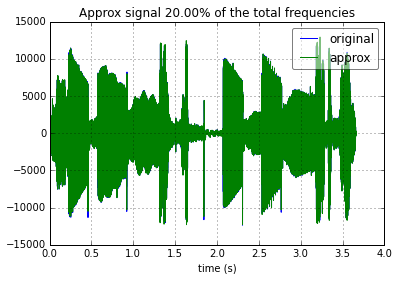

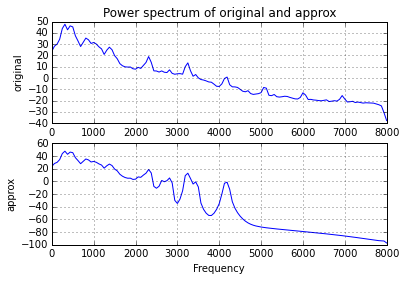

In [8]:
plot_approx(x, xapprox, frac, rate)

Connvert the compressed signal to a format suitable for writing and save it
to disk

In [9]:
# linearly rescale raw data to wav range and convert to integers
sound = xapprox.astype(np.int16)
basename, ext = os.path.splitext(infile)
new_filename = '%s_frac%d.wav' % (basename, 100*frac) 
wavfile.write(new_filename, rate, sound)

Although having `.wav` files on disk is useful to play them with other tools, we can listen to the audio directly with IPython's Audio object:

In [13]:
print("Original")
display(Audio(infile))
print("Compressed, keeping only %s of original data" % frac)
display(Audio(data=sound, rate=rate))

Original


Compressed, keeping only 0.2 of original data
